In [13]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Conv2D, Dense, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# Variable declaration
Just specifying variables to be used

In [14]:
img_width, img_height = 48,48

class_names = ['angry', 'disgust', 'fear', 'happy',
               'neutral', 'sad', 'surprise']

global_dir = "C:/Users/matty/Desktop/Gordon/Assignment 2/"

train_data_dir = global_dir + "dataset/train/"
test_data_dir = global_dir + "dataset/test/"

# ImageDataGenerator Instantiation
Various parameters are changed here, some are commented, some are self explanatory

In [15]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,        
    validation_split = 0.2,  # 20% split
    horizontal_flip = True,  # Change to flip some images
    rotation_range = 30,     # Chance to rotate images by maximum of 15 degrees
    zoom_range = 0.1         # Chance to zoom in on an image by 10%
)        
test_datagen = ImageDataGenerator(
    rescale = 1./255
)
val_datagen = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2
)

train_generator = train_datagen.flow_from_directory(
    target_size = (img_width, img_height),
    directory = (train_data_dir),
    color_mode = "grayscale",
    class_mode = "categorical",
    subset = "training",
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    target_size = (img_width, img_height),
    directory = (train_data_dir),
    color_mode = "grayscale",
    class_mode = "categorical",
    subset = "validation",
    shuffle = True
)

test_generator = test_datagen.flow_from_directory(
    target_size = (img_width, img_height),
    directory = (test_data_dir),
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle = False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [16]:
# Classes is a variable needed for the model - just the number of classes
classes = len(train_generator.class_indices.items())

# Model Building

In [17]:
# Original Lenet architecture which was the base architecture for my model
# lenet = Sequential([
#    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_width,img_height,1)),
#    MaxPooling2D(strides = 2),
#    Conv2D(64, kernel_size=(3, 3), activation='relu'),
#    MaxPooling2D(strides = 2),
#    Flatten(),
#    Dense(256, activation='relu'),
#    Dense(84, activation='relu'),
#    Dense(units=classes, activation = 'softmax'),
# ])

model2 = Sequential([
    Conv2D(
        filters = 32,                # Number of output filters
        kernel_size = (5, 5),        # Similar to a sampling size. Usually smaller would be better for smaller images, but 5x5 proved the best
        activation = 'relu',         # Activation function. As explained in report, relu was the better choice
        input_shape = (img_width,img_height,1)
    ),
    Conv2D(
        filters = 64, 
        kernel_size = (5, 5),
        activation = 'relu'
    ),
    MaxPooling2D(
        strides = 2                   # Stride of the filter downsamples the output feature map
    ),
    Dropout(
        rate = 0.3                    # Rate that neurons will be dropped 
    ),
    Conv2D(
        filters = 128, 
        kernel_size=(5, 5), 
        activation='relu', 
        kernel_regularizer = regularizers.l2(0.0001)  # L2 regularisation as explained in report
    ),
    Dropout(
        rate = 0.3
    ),
    MaxPooling2D(
        strides = 2
    ),
    Dropout(
        rate = 0.3
    ),
    Flatten(),                         # Transforming the data into a single column to pass to the dense layers
    Dense(
        units = 4096,                  # Amount of neurons
        activation='relu'
    ),
    Dropout(
        rate = 0.3
    ),
    Dense(
        units = 2048, 
        activation='relu'
    ),
    Dropout(
        rate = 0.2
    ),
    Dense(
        units = 84, 
        activation='relu'
    ),
    Dropout(
        rate = 0.2
    ),
    Dense(
        units = classes, 
        activation = 'softmax'          # Output activation function is softmax as it is multi class classification
    ),
])

model2.compile(
    optimizer = SGD(                    # SGD optimizer
        lr = 0.01,                      # Best learning rate achieved was 0.01
        momentum = 0.8                  # Best momentum achieved was 0.8
        ),
    loss = 'categorical_crossentropy',  # Multi class classification
    metrics = ['accuracy']             
)

early_stop = EarlyStopping(             # EarlyStopping callback
    monitor = "val_accuracy",           # Monitoring the val_accuracy
    min_delta = 0,                      
    patience = 4,                       # Give it 'x' amount of goes if it doesn't improve before we stop
    verbose = 1,                        # Output when stopped
    mode = "auto"
)

checkpoint = ModelCheckpoint(           # ModelCheckpoint callback
    filepath = "best.hdf5",             # Filename for best model
    monitor = "val_accuracy",           # Basing the best model on val_accuracy
    verbose = 1,                        
    save_best_only = True,              # Only update if an improvement is made
    mode = "max"                        # Higher number wanted
)

csv_logger = CSVLogger(                 # CSVLogger callback
    filename = "training.csv", 
    separator = ",",
    append = True   
)

callbacks = [early_stop, checkpoint, csv_logger]

# Model Training

In [18]:
history = model2.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 100,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/100
718/718 [==============================] - 32s 43ms/step - loss: 1.8431 - accuracy: 0.2435 - val_loss: 1.8195 - val_accuracy: 0.2513

Epoch 00001: val_accuracy improved from -inf to 0.25135, saving model to best.hdf5
Epoch 2/100
718/718 [==============================] - 31s 43ms/step - loss: 1.8025 - accuracy: 0.2475 - val_loss: 1.7502 - val_accuracy: 0.2792

Epoch 00002: val_accuracy improved from 0.25135 to 0.27922, saving model to best.hdf5
Epoch 3/100
718/718 [==============================] - 31s 43ms/step - loss: 1.7521 - accuracy: 0.2886 - val_loss: 1.7113 - val_accuracy: 0.3020

Epoch 00003: val_accuracy improved from 0.27922 to 0.30204, saving model to best.hdf5
Epoch 4/100
718/718 [==============================] - 31s 43ms/step - loss: 1.7080 - accuracy: 0.3179 - val_loss: 1.6491 - val_accuracy: 0.3489

Epoch 00004: val_accuracy improved from 0.30204 to 0.34889, saving model to best.hdf5
Epoch 5/100
718/718 [==============================] - 31s 43ms/step - loss

# Graphing
This section shows some graphs for the model outlining training and validation accuracy and loss.

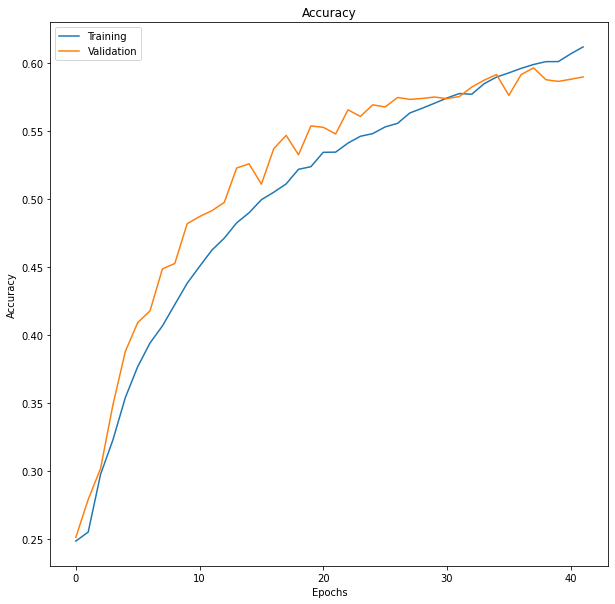

In [19]:
plt.figure(figsize = (10, 10))
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"])

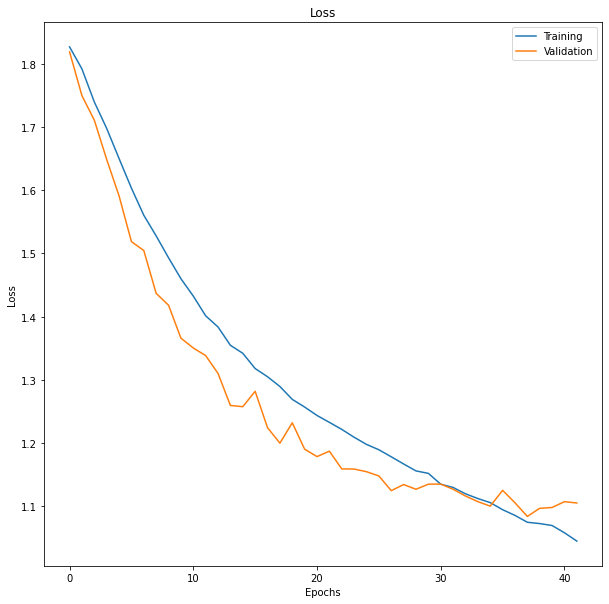

In [20]:
plt.figure(figsize = (10, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])

# Model Evaluation
This is the evaluation of the best model which is saved.

In [21]:
saved_model = load_model("best.hdf5")

train_acc = saved_model.evaluate(train_generator)
test_acc = saved_model.evaluate(test_generator)

225/225 [==============================] - 4s 19ms/step - loss: 1.0807 - accuracy: 0.5936


## Confusion Matrix
The confusion matrix is prepared (conMatrix) and can be printed, but this has been visualised in pyplot.

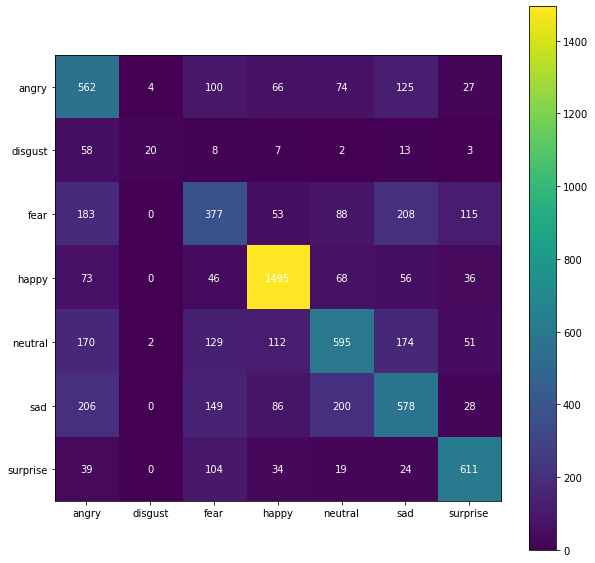

In [22]:
pred = np.argmax(model2.predict(test_generator), axis = 1)

conMatrix = confusion_matrix(test_generator.classes, pred)

plt.figure(figsize = (10, 10))
plt.imshow(conMatrix, cmap="viridis")
plt.colorbar()
plt.xticks(np.arange(classes),labels=class_names)
plt.yticks(np.arange(classes), labels=class_names)

for i in range (classes):
  for j in range (classes):
    text = plt.text(j, i, conMatrix[i, j], ha = "center", va = "center", color = "white")

In [23]:
classReport = classification_report(test_generator.classes, pred, target_names = class_names)
print(classReport)

              precision    recall  f1-score   support

       angry       0.44      0.59      0.50       958
     disgust       0.77      0.18      0.29       111
        fear       0.41      0.37      0.39      1024
       happy       0.81      0.84      0.82      1774
     neutral       0.57      0.48      0.52      1233
         sad       0.49      0.46      0.48      1247
    surprise       0.70      0.74      0.72       831

    accuracy                           0.59      7178
   macro avg       0.60      0.52      0.53      7178
weighted avg       0.59      0.59      0.59      7178

